In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pymannkendall as mk
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
%matplotlib inline

# Load the data and process date
df = pd.read_csv('data/dm.csv')
df['DATE'] = pd.to_datetime(df['DATE'], format='mixed')
df["year"] = df["DATE"].dt.year
df = df[df["year"]>1976]
df = df[df["year"]<2024]
df["month"] = df["DATE"].dt.month

# Function to categorize seasons
def define_season(month):
    if 6 <= month < 11:
        return "Monsoon"
    else:
        return "Non-monsoon"

# Apply season function and filter out zero rainfall data
df['season'] = df['month'].apply(define_season)
without_zero = df[df['PRCP'] > 0]


In [2]:
# Grouped data calculations for monthly, seasonal, and yearly means
grouped = without_zero.groupby(["year", 'month'])
all_mean_rainfall_monthly = grouped["PRCP"].sum().to_dict()

grouped_season = without_zero.groupby(["year", 'season'])["PRCP"].sum().to_dict()
grouped_year = without_zero.groupby("year")["PRCP"].sum().to_dict() # take sum instead of mean

# Initialize DataFrames for storing monthly and yearly rainfall data
raindata = pd.DataFrame(columns=range(1, 13))
raindata_yearly = pd.DataFrame(columns=["Annual"])

# Populate monthly rainfall data
for j in all_mean_rainfall_monthly:
    raindata.at[j[0], j[1]] = all_mean_rainfall_monthly[j]

# Rename columns with month names
mapping = {
    1: "Jan", 2: "Feb", 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'July', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
raindata = raindata.rename(columns=mapping)

In [3]:
# DataFrame to store concordant and discordant statistics
conc_disc = pd.DataFrame(columns=raindata.columns)

# Loop through each month and calculate statistics
for month in raindata.columns:
    data_point = list(raindata[month].dropna())
    concordant = 0
    discordant = 0
    slopes = []

    # Calculate concordant and discordant pairs
    for idx, i in enumerate(data_point[:-1]):
        for idx2, j in enumerate(data_point[idx + 1:]):
            slopes.append((i - j) / (idx2 + 1))
            if (j - i) > 0:
                concordant += 1
            elif (j - i) < 0:
                discordant += 1

    # Store results in conc_disc DataFrame
    conc_disc.at['concordant', month] = concordant
    conc_disc.at['discordant', month] = discordant
    conc_disc.at['S', month] = concordant - discordant
    conc_disc.at['Kendall Tau', month] = (concordant - discordant) / (concordant + discordant) if (concordant + discordant) != 0 else np.nan
    conc_disc.at['Min', month] = np.min(data_point)
    conc_disc.at['Mean', month] = np.mean(data_point)
    conc_disc.at['Max', month] = np.max(data_point)
    conc_disc.at['Standard Deviation', month] = np.std(data_point)
    conc_disc.at['Sens Slope', month] = np.median(slopes)


In [4]:
# Mann-Kendall statistics for annual rainfall
concordant = 0
discordant = 0
slopes = []
data_point = list(grouped_year.values())

for idx, i in enumerate(data_point[:-1]):
    for idx2, j in enumerate(data_point[idx + 1:]):
        slopes.append((i - j) / (idx2 + 1))
        if (j - i) > 0:
            concordant += 1
        elif (j - i) < 0:
            discordant += 1

# Store results for annual data
conc_disc.at['concordant', "Annual"] = concordant
conc_disc.at['discordant', "Annual"] = discordant
conc_disc.at['S', "Annual"] = concordant - discordant
conc_disc.at['Kendall Tau', "Annual"] = (concordant - discordant) / (concordant + discordant) if (concordant + discordant) != 0 else np.nan
conc_disc.at['Min', "Annual"] = np.min(data_point)
conc_disc.at['Mean', "Annual"] = np.mean(data_point)
conc_disc.at['Max', "Annual"] = np.max(data_point)
conc_disc.at['Standard Deviation', "Annual"] = np.std(data_point)
conc_disc.at['Sens Slope', "Annual"] = np.median(slopes)


In [5]:
# DataFrame to store seasonal statistics
conc_disc_seasonal = pd.DataFrame(columns=["Monsoon", "Non-monsoon"])

# Loop through each season to calculate statistics
for season in ["Monsoon", "Non-monsoon"]:
    data_point = list(without_zero[without_zero["season"] == season].groupby("year")["PRCP"].sum().dropna())
    concordant = 0
    discordant = 0
    slopes = []

    for idx, i in enumerate(data_point[:-1]):
        for idx2, j in enumerate(data_point[idx + 1:]):
            slopes.append((i - j) / (idx2 + 1))
            if (j - i) > 0:
                concordant += 1
            elif (j - i) < 0:
                discordant += 1

    # Store results for each season
    conc_disc_seasonal.at["concordant", season] = concordant
    conc_disc_seasonal.at["discordant", season] = discordant
    conc_disc_seasonal.at["S", season] = concordant - discordant
    conc_disc_seasonal.at["Kendall Tau", season] = (concordant - discordant) / (concordant + discordant) if (concordant + discordant) != 0 else np.nan
    conc_disc_seasonal.at["Min", season] = np.min(data_point)
    conc_disc_seasonal.at["Mean", season] = np.mean(data_point)
    conc_disc_seasonal.at["Max", season] = np.max(data_point)
    conc_disc_seasonal.at["Standard Deviation", season] = np.std(data_point)
    conc_disc_seasonal.at["Sens Slope", season] = np.median(slopes)


In [6]:
# Cell 7: Combine Monthly, Annual, and Seasonal Data into a Single DataFrame
# Concatenate conc_disc (monthly + annual data) and conc_disc_seasonal (seasonal data)
final_results = pd.concat([conc_disc, conc_disc_seasonal], axis=1)

# Display the final combined DataFrame
print("Combined Monthly, Annual, and Seasonal Statistics:")
display(final_results)

Combined Monthly, Annual, and Seasonal Statistics:


,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,Annual,Monsoon,Non-monsoon
concordant,523,559,648,689,742,765,666,689,546,590,386,315,745.000000,739,764
discordant,464,426,386,345,338,316,415,392,444,444,353,344,336.000000,342,317
S,59,133,262,344,404,449,251,297,102,146,33,-29,409.000000,397,447
Kendall Tau,0.059777,0.135025,0.253385,0.332689,0.374074,0.415356,0.232192,0.274746,0.10303,0.141199,0.044655,-0.044006,0.378353,0.367253,0.413506
Min,0.3,0.8,3.0,13.9,4.1,37.1,27.6,9.5,31.7,1.3,0.3,0.3,276.400000,127.6,44.6
Mean,20.831111,46.84,73.073913,157.65,251.278723,305.617021,364.674468,288.644681,256.304444,112.791304,22.146154,14.435135,1886.351064,1314.725532,571.625532
Max,89.2,149.8,210.4,538.1,1231.2,736.6,752.3,755.5,622.9,267.1,192.0,58.5,2990.300000,2271.3,1687.5
Standard Deviation,20.85663,39.042105,57.040963,108.575539,203.057274,166.466075,155.631402,169.404242,142.237779,68.6263,31.842673,15.342684,688.990516,488.205465,324.622904
Sens Slope,-0.07418,-0.437353,-1.166667,-3.444444,-5.697059,-6.984615,-4.233333,-6.136364,-1.359211,-1.252,-0.083333,0.03891,-30.142105,-20.3075,-11.57


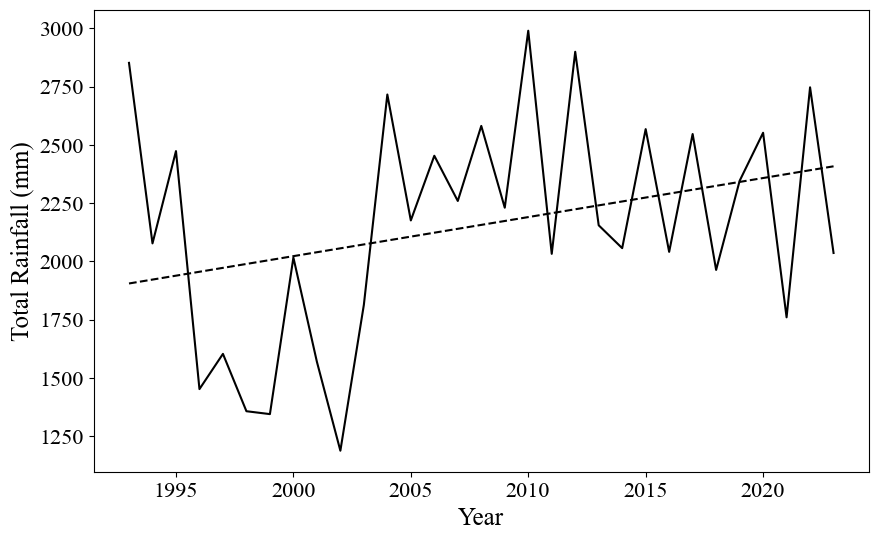

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `grouped_year` contains your rainfall data by year
# Filtering the data to only include years from 1977 to 2023
annual_rainfall_df = pd.DataFrame(grouped_year, index=[0]).T.reset_index()
annual_rainfall_df.columns = ['year', 'mean_rainfall']
annual_rainfall_df = annual_rainfall_df[(annual_rainfall_df['year'] >= 1993) & (annual_rainfall_df['year'] <= 2023)]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(annual_rainfall_df['year'], annual_rainfall_df['mean_rainfall'], label="Mean Rainfall",color='black')

# Adding a trend line
z = np.polyfit(annual_rainfall_df['year'], annual_rainfall_df['mean_rainfall'], 1)
p = np.poly1d(z)
plt.plot(annual_rainfall_df['year'], p(annual_rainfall_df['year']), 'k--', label="Trend Line")

# Adding titles and labels
#plt.title('Annual Mean Rainfall Trend (1977 - 2023)', fontsize=16)
#plt.xlabel('Year', fontsize=14)
#plt.ylabel('Mean Rainfall', fontsize=14)
#plt.legend()
plt.xlabel('Year',fontname='Times New Roman', fontsize=18)
plt.ylabel('Total Rainfall (mm)',fontname='Times New Roman', fontsize=18)
# Adjusting the font size of x-axis and y-axis numbers (tick labels)
plt.tick_params(axis='x', labelsize=16, labelfontfamily='Times New Roman')  # Change the font size for x-axis numbers
plt.tick_params(axis='y', labelsize=16,labelfontfamily='Times New Roman')  #

plt.show()




Mann-Kendall Trend Equation: y = 16.7681x + -31513.6284


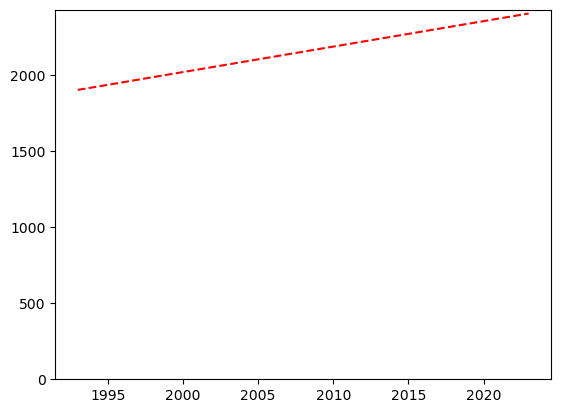

In [8]:
from scipy import stats

# Fit the trend line using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(annual_rainfall_df["year"], annual_rainfall_df["mean_rainfall"])

# Plot the trend line
plt.plot(annual_rainfall_df["year"], slope * annual_rainfall_df["year"] + intercept, 'r--')
plt.ylim(bottom=0)
# Display the equation of the Mann-Kendall trend line
trend_equation = f"y = {slope:.4f}x + {intercept:.4f}"
print("Mann-Kendall Trend Equation:", trend_equation)


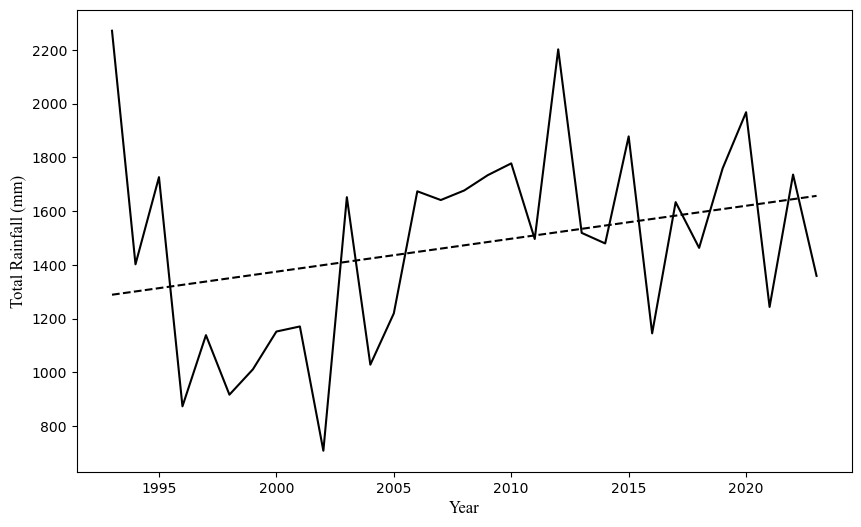

In [9]:
import matplotlib.pyplot as plt

seasonal = without_zero.groupby(["year", 'season'])["PRCP"].sum().to_dict()

seasonal_new = {}
for i in seasonal:
    if(i[1]=="Monsoon"):
        seasonal_new[i[0]]=seasonal[i]

annual_seasonal_df = pd.DataFrame(seasonal_new,index=[0]).T.reset_index()
annual_seasonal_df.columns = ['year', 'mean_rainfall']
annual_seasonal_df = annual_seasonal_df[(annual_seasonal_df['year'] >= 1993) & (annual_seasonal_df['year'] <= 2023)]
plt.figure(figsize=(10, 6))
plt.plot(annual_seasonal_df['year'], annual_seasonal_df['mean_rainfall'], color='black')

z = np.polyfit(annual_seasonal_df['year'], annual_seasonal_df['mean_rainfall'], 1)
p = np.poly1d(z)
plt.plot(annual_seasonal_df['year'], p(annual_seasonal_df['year']), 'k--')


plt.xlabel('Year',fontname='Times New Roman', fontsize=12)
plt.ylabel('Total Rainfall (mm)',fontname='Times New Roman', fontsize=12)
ax = plt.gca()


plt.show()

Mann-Kendall Trend Equation: y = 12.2604x + -23145.8055


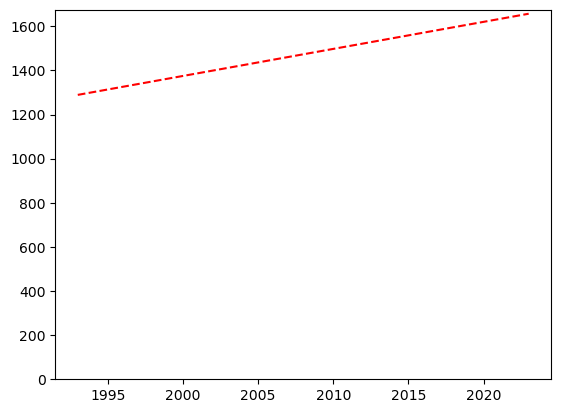

In [10]:
from scipy import stats

# Fit the trend line using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(annual_seasonal_df["year"], annual_seasonal_df["mean_rainfall"])

# Plot the trend line
plt.plot(annual_seasonal_df["year"], slope * annual_seasonal_df["year"] + intercept, 'r--')
plt.ylim(bottom=0)
# Display the equation of the Mann-Kendall trend line
trend_equation = f"y = {slope:.4f}x + {intercept:.4f}"
print("Mann-Kendall Trend Equation:", trend_equation)


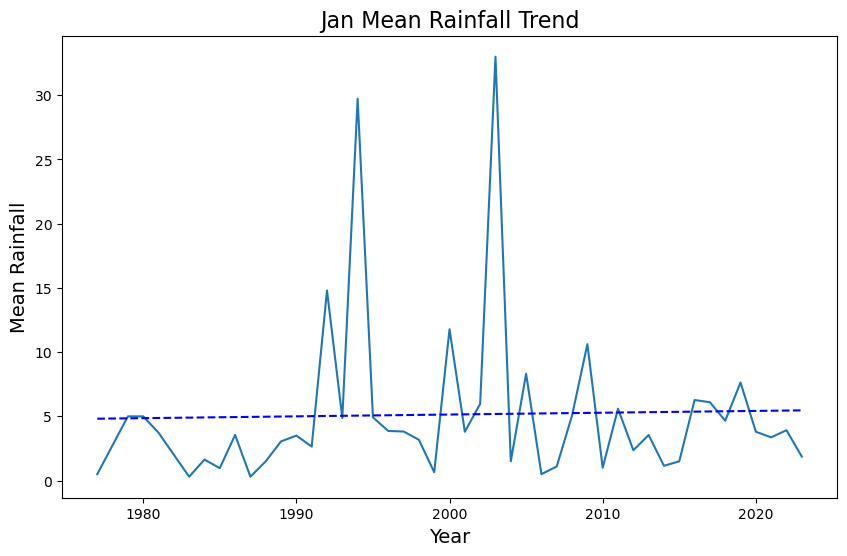

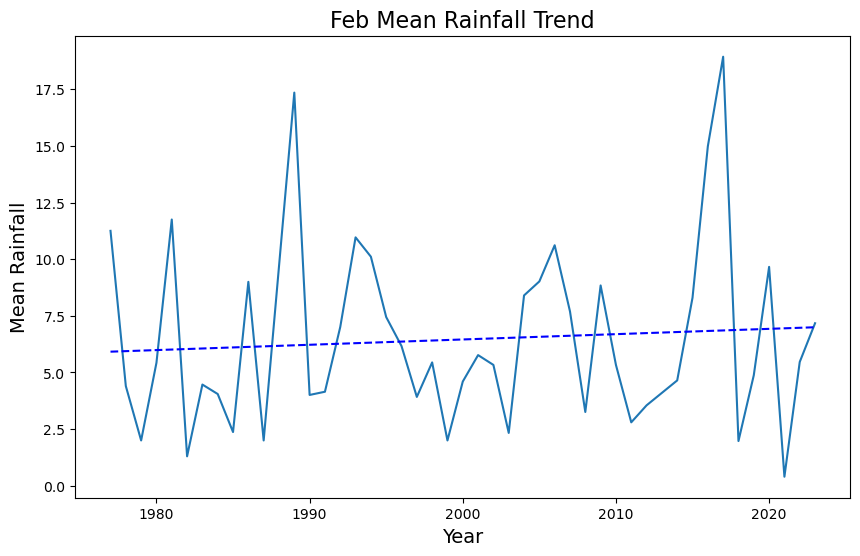

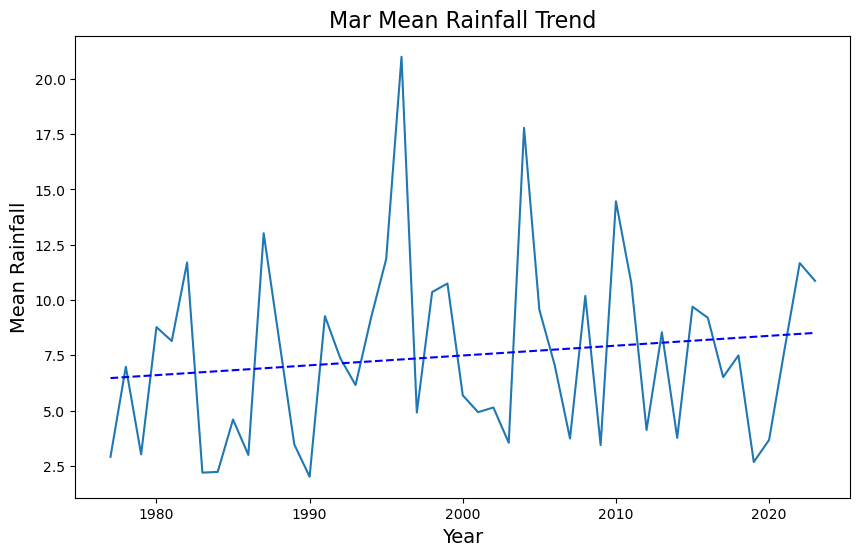

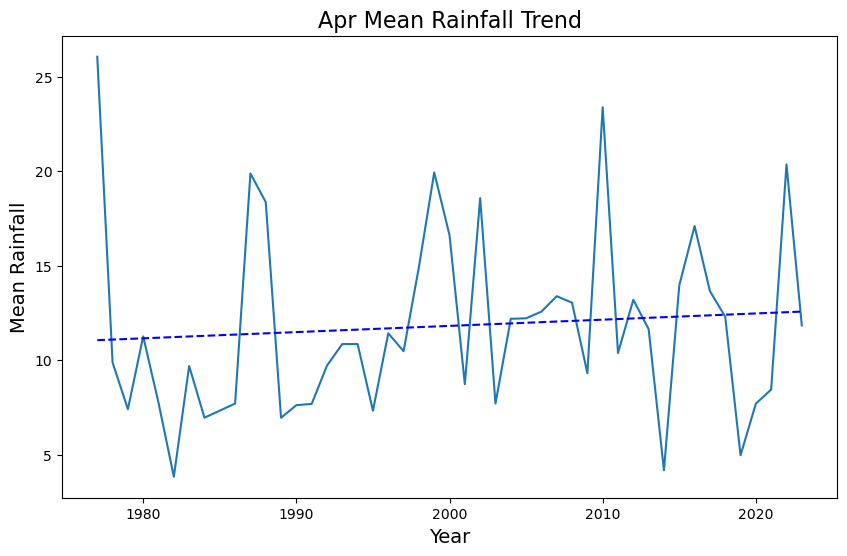

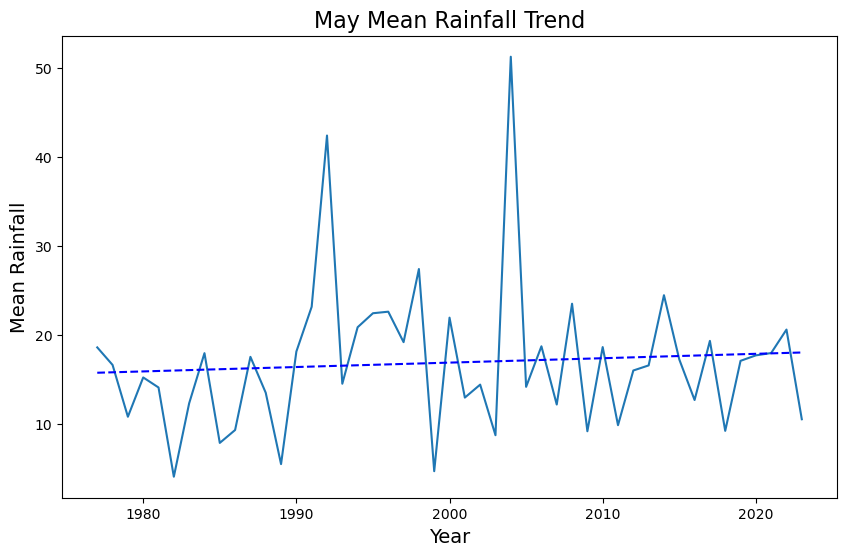

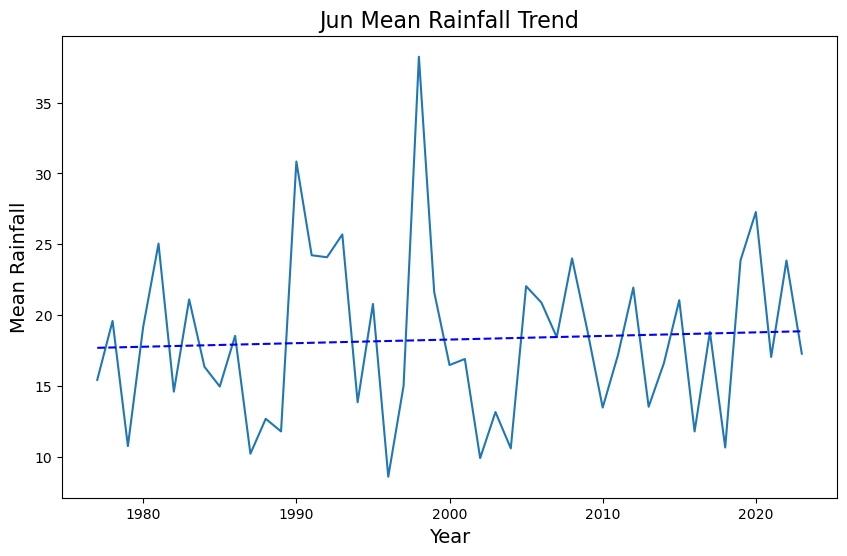

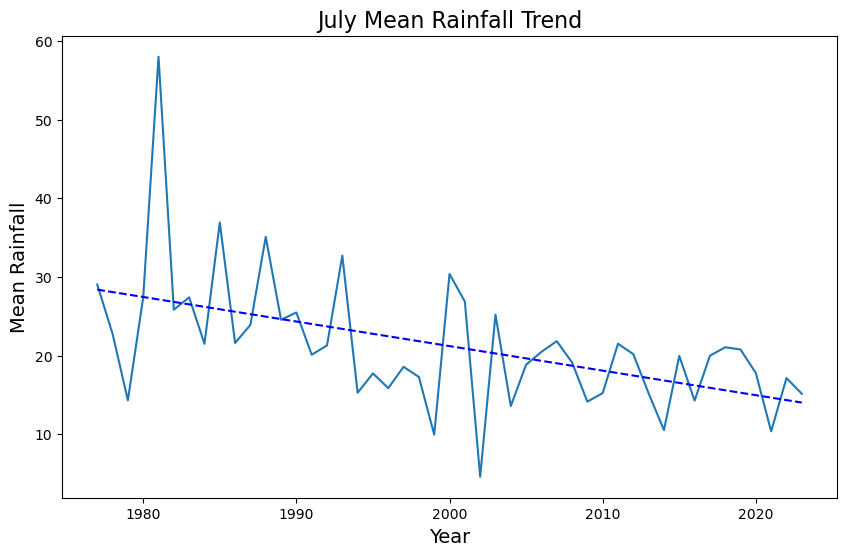

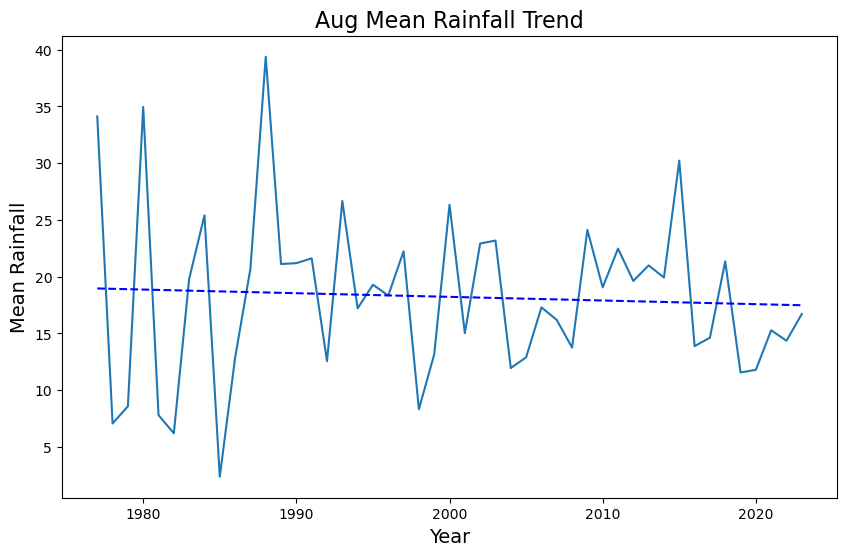

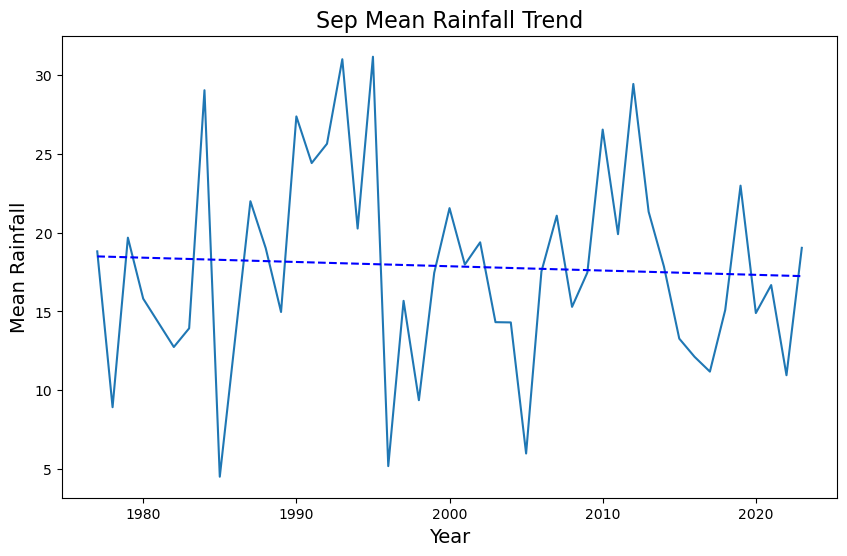

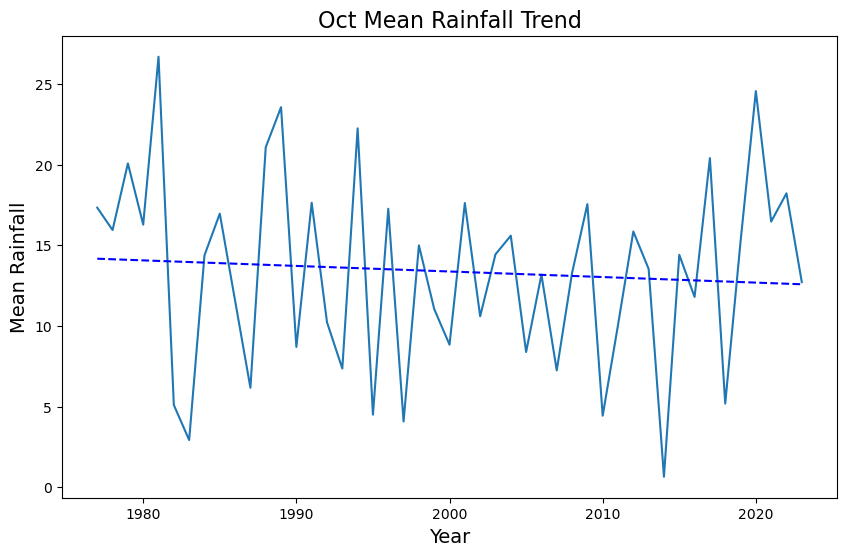

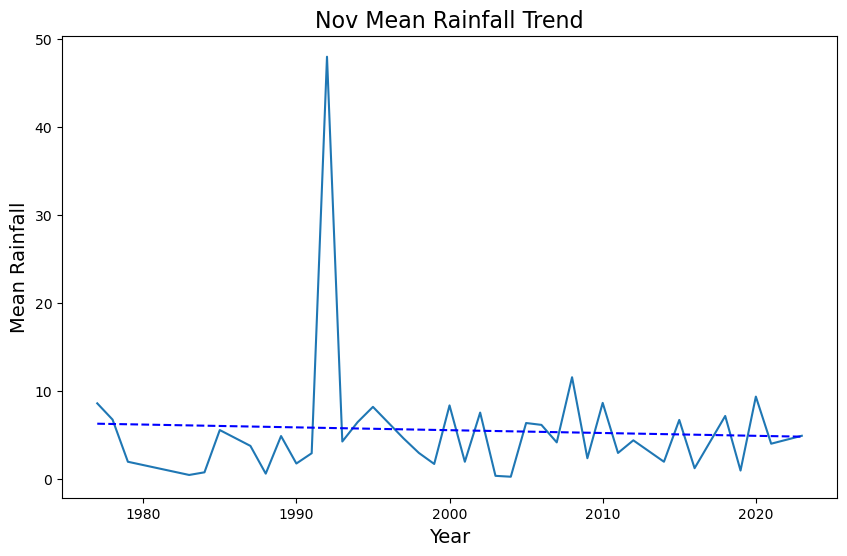

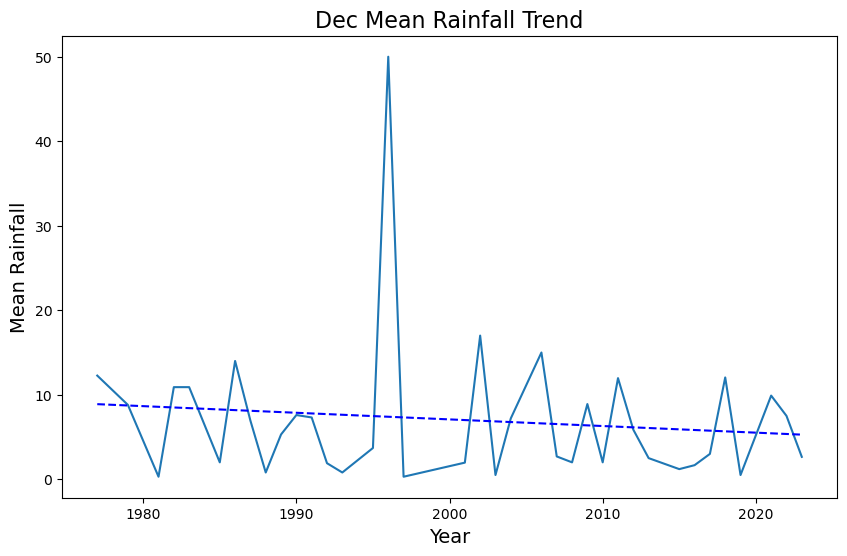

In [11]:
import matplotlib.pyplot as plt

monthly = without_zero.groupby(["year", 'month'])["PRCP"].mean().to_dict()
monthly_new = {}
for i in monthly:
    if(i[1] not in monthly_new):
        monthly_new[i[1]] = {}
    monthly_new[i[1]][i[0]]=monthly[i]

for month_ in monthly_new:
    annual_monthly_df = pd.DataFrame(monthly_new[month_],index=[0]).T.reset_index()
    annual_monthly_df.columns = ['year', 'mean_rainfall']
    plt.figure(figsize=(10, 6))
    plt.plot(annual_monthly_df['year'], annual_monthly_df['mean_rainfall'])

    z = np.polyfit(annual_monthly_df['year'], annual_monthly_df['mean_rainfall'], 1)
    p = np.poly1d(z)
    plt.plot(annual_monthly_df['year'], p(annual_monthly_df['year']), 'b--')

    plt.title(f'{mapping[month_]} Mean Rainfall Trend',fontsize=16)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Mean Rainfall',fontsize=14)

    plt.show()

In [12]:
from scipy.stats import kendalltau
import numpy as np
import pandas as pd

# DataFrame to store concordant and discordant statistics
conc_disc = pd.DataFrame(columns=raindata.columns)

# Loop through each month and calculate statistics
for month in raindata.columns:
    data_point = list(raindata[month].dropna())
    concordant = 0
    discordant = 0
    slopes = []

    # Calculate concordant and discordant pairs
    for idx, i in enumerate(data_point[:-1]):
        for idx2, j in enumerate(data_point[idx + 1:]):
            slopes.append((i - j) / (idx2 + 1))
            if (j - i) > 0:
                concordant += 1
            elif (j - i) < 0:
                discordant += 1
    tau, p_value = kendalltau(data_point, range(len(data_point)))

    # Store results in conc_disc DataFrame
    conc_disc.at['concordant', month] = concordant
    conc_disc.at['discordant', month] = discordant
    conc_disc.at['S', month] = concordant - discordant
    conc_disc.at['Kendall Tau', month] = (concordant - discordant) / (concordant + discordant) if (concordant + discordant) != 0 else np.nan
    conc_disc.at['p-value', month] = p_value
    conc_disc.at['Min', month] = np.min(data_point)
    conc_disc.at['Mean', month] = np.mean(data_point)
    conc_disc.at['Max', month] = np.max(data_point)
    conc_disc.at['Standard Deviation', month] = np.std(data_point)
    conc_disc.at['Sens Slope', month] = np.median(slopes)

# Assume conc_disc DataFrame and grouped_year data are defined
concordant = 0
discordant = 0
slopes = []
data_point = list(grouped_year.values())

# Calculate concordant and discordant pairs, and slopes
for idx, i in enumerate(data_point[:-1]):
    for idx2, j in enumerate(data_point[idx + 1:]):
        slopes.append((i - j) / (idx2 + 1))
        if (j - i) > 0:
            concordant += 1
        elif (j - i) < 0:
            discordant += 1

# Calculate Kendall's Tau and p-value
tau, p_value = kendalltau(data_point, range(len(data_point)))

# Store results for annual data
conc_disc.at['concordant', "Annual"] = concordant
conc_disc.at['discordant', "Annual"] = discordant
conc_disc.at['S', "Annual"] = concordant - discordant
conc_disc.at['Kendall Tau', "Annual"] = tau
conc_disc.at['p-value', "Annual"] = p_value
conc_disc.at['Min', "Annual"] = np.min(data_point)
conc_disc.at['Mean', "Annual"] = np.mean(data_point)
conc_disc.at['Max', "Annual"] = np.max(data_point)
conc_disc.at['Standard Deviation', "Annual"] = np.std(data_point)
conc_disc.at['Sens Slope', "Annual"] = np.median(slopes)


In [13]:


conc_disc

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,Annual
concordant,523,559,648,689,742,765,666,689,546,590,386,315,745.000000
discordant,464,426,386,345,338,316,415,392,444,444,353,344,336.000000
S,59,133,262,344,404,449,251,297,102,146,33,-29,409.000000
Kendall Tau,0.059777,0.135025,0.253385,0.332689,0.374074,0.415356,0.232192,0.274746,0.10303,0.141199,0.044655,-0.044006,0.378353
p-value,0.563778,0.193121,0.01311,0.001125,0.000211,0.000038,0.021347,0.006457,0.318378,0.166845,0.689705,0.70429,0.000176
Min,0.3,0.8,3.0,13.9,4.1,37.1,27.6,9.5,31.7,1.3,0.3,0.3,276.400000
Mean,20.831111,46.84,73.073913,157.65,251.278723,305.617021,364.674468,288.644681,256.304444,112.791304,22.146154,14.435135,1886.351064
Max,89.2,149.8,210.4,538.1,1231.2,736.6,752.3,755.5,622.9,267.1,192.0,58.5,2990.300000
Standard Deviation,20.85663,39.042105,57.040963,108.575539,203.057274,166.466075,155.631402,169.404242,142.237779,68.6263,31.842673,15.342684,688.990516
Sens Slope,-0.07418,-0.437353,-1.166667,-3.444444,-5.697059,-6.984615,-4.233333,-6.136364,-1.359211,-1.252,-0.083333,0.03891,-30.142105


In [14]:
# DataFrame to store seasonal statistics
conc_disc_seasonal = pd.DataFrame(columns=["Monsoon", "Non-monsoon"])

# Loop through each season to calculate statistics
for season in ["Monsoon", "Non-monsoon"]:
    data_point = list(without_zero[without_zero["season"] == season].groupby("year")["PRCP"].mean().dropna())
    concordant = 0
    discordant = 0
    slopes = []

    for idx, i in enumerate(data_point[:-1]):
        for idx2, j in enumerate(data_point[idx + 1:]):
            slopes.append((i - j) / (idx2 + 1))
            if (j - i) > 0:
                concordant += 1
            elif (j - i) < 0:
                discordant += 1

    # Calculate Kendall's tau and p-value
    tau, p_value = kendalltau(data_point, range(len(data_point)))

    # Store results for each season
    conc_disc_seasonal.at["concordant", season] = concordant
    conc_disc_seasonal.at["discordant", season] = discordant
    conc_disc_seasonal.at["S", season] = concordant - discordant
    conc_disc_seasonal.at["Kendall Tau", season] = (concordant - discordant) / (concordant + discordant) if (concordant + discordant) != 0 else np.nan
    conc_disc_seasonal.at["p-value", season] = p_value
    conc_disc_seasonal.at["Min", season] = np.min(data_point)
    conc_disc_seasonal.at["Mean", season] = np.mean(data_point)
    conc_disc_seasonal.at["Max", season] = np.max(data_point)
    conc_disc_seasonal.at["Standard Deviation", season] = np.std(data_point)
    conc_disc_seasonal.at["Sens Slope", season] = np.median(slopes)


In [15]:
conc_disc_seasonal

,Monsoon,Non-monsoon
concordant,448,632
discordant,633,449
S,-185,183
Kendall Tau,-0.171138,0.169288
p-value,0.089785,0.093309
Min,12.702469,2.773684
Mean,18.676539,10.79703
Max,33.721739,27.217742
Standard Deviation,3.920183,3.883063
Sens Slope,0.065671,-0.070671


In [16]:
from scipy.stats import kendalltau
import numpy as np
import pandas as pd

# DataFrame to store concordant and discordant statistics
conc_disc = pd.DataFrame(columns=raindata.columns)

# Loop through each month and calculate statistics
for month in raindata.columns:
    data_point = list(raindata[month].dropna())
    concordant = 0
    discordant = 0
    slopes = []

    # Calculate concordant and discordant pairs
    for idx, i in enumerate(data_point[:-1]):
        for idx2, j in enumerate(data_point[idx + 1:]):
            slopes.append((i - j) / (idx2 + 1))
            if (j - i) > 0:
                concordant += 1
            elif (j - i) < 0:
                discordant += 1

    # Calculate Kendall's Tau and p-value
    tau, p_value = kendalltau(data_point, range(len(data_point)))

    # Variance and standard deviation of the test statistic S
    S = concordant - discordant
    n = len(data_point)
    var_S = (n * (n - 1) * (2 * n + 5)) / 18  # Variance formula for Kendall's S
    std_dev_S = np.sqrt(var_S) if var_S > 0 else np.nan

    # Store results in conc_disc DataFrame
    conc_disc.at['concordant', month] = concordant
    conc_disc.at['discordant', month] = discordant
    conc_disc.at['S', month] = S
    conc_disc.at['Variance S', month] = var_S
    conc_disc.at['Standard Deviation S', month] = std_dev_S
    conc_disc.at['Kendall Tau', month] = tau
    conc_disc.at['p-value', month] = p_value
    conc_disc.at['Min', month] = np.min(data_point)
    conc_disc.at['Mean', month] = np.mean(data_point)
    conc_disc.at['Max', month] = np.max(data_point)
    conc_disc.at['Standard Deviation', month] = np.std(data_point)
    conc_disc.at['Sens Slope', month] = np.median(slopes)

# Calculate statistics for annual data (assuming grouped_year is defined)
concordant = 0
discordant = 0
slopes = []
data_point = list(grouped_year.values())

# Calculate concordant and discordant pairs, and slopes
for idx, i in enumerate(data_point[:-1]):
    for idx2, j in enumerate(data_point[idx + 1:]):
        slopes.append((i - j) / (idx2 + 1))
        if (j - i) > 0:
            concordant += 1
        elif (j - i) < 0:
            discordant += 1

# Calculate Kendall's Tau and p-value
tau, p_value = kendalltau(data_point, range(len(data_point)))

# Variance and standard deviation of S for annual data
S = concordant - discordant
n = len(data_point)
var_S = (n * (n - 1) * (2 * n + 5)) / 18
std_dev_S = np.sqrt(var_S) if var_S > 0 else np.nan

# Store results for annual data
conc_disc.at['concordant', "Annual"] = concordant
conc_disc.at['discordant', "Annual"] = discordant
conc_disc.at['S', "Annual"] = S
conc_disc.at['Variance S', "Annual"] = var_S
conc_disc.at['Standard Deviation S', "Annual"] = std_dev_S
conc_disc.at['Kendall Tau', "Annual"] = tau
conc_disc.at['p-value', "Annual"] = p_value
conc_disc.at['Min', "Annual"] = np.min(data_point)
conc_disc.at['Mean', "Annual"] = np.mean(data_point)
conc_disc.at['Max', "Annual"] = np.max(data_point)
conc_disc.at['Standard Deviation', "Annual"] = np.std(data_point)
conc_disc.at['Sens Slope', "Annual"] = np.median(slopes)


In [17]:
conc_disc

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,Annual
concordant,523,559,648,689,742,765,666,689,546,590,386,315,745.000000
discordant,464,426,386,345,338,316,415,392,444,444,353,344,336.000000
S,59,133,262,344,404,449,251,297,102,146,33,-29,409.000000
Variance S,10450.0,10450.0,11155.0,11155.0,11891.0,11891.0,11891.0,11891.0,10450.0,11155.0,6833.666667,5846.0,11891.000000
Standard Deviation S,102.225242,102.225242,105.617233,105.617233,109.045862,109.045862,109.045862,109.045862,102.225242,105.617233,82.665995,76.459139,109.045862
Kendall Tau,0.059686,0.134684,0.253262,0.332528,0.373901,0.415356,0.232192,0.274746,0.10303,0.141131,0.044595,-0.043774,0.378353
p-value,0.563778,0.193121,0.01311,0.001125,0.000211,0.000038,0.021347,0.006457,0.318378,0.166845,0.689705,0.70429,0.000176
Min,0.3,0.8,3.0,13.9,4.1,37.1,27.6,9.5,31.7,1.3,0.3,0.3,276.400000
Mean,20.831111,46.84,73.073913,157.65,251.278723,305.617021,364.674468,288.644681,256.304444,112.791304,22.146154,14.435135,1886.351064
Max,89.2,149.8,210.4,538.1,1231.2,736.6,752.3,755.5,622.9,267.1,192.0,58.5,2990.300000


In [18]:
from scipy.stats import kendalltau
import numpy as np
import pandas as pd

# DataFrame to store seasonal statistics
conc_disc_seasonal = pd.DataFrame(columns=["Monsoon", "Non-monsoon"])

# Loop through each season to calculate statistics
for season in ["Monsoon", "Non-monsoon"]:
    data_point = list(without_zero[without_zero["season"] == season].groupby("year")["PRCP"].sum().dropna())
    concordant = 0
    discordant = 0
    slopes = []

    # Calculate concordant and discordant pairs
    for idx, i in enumerate(data_point[:-1]):
        for idx2, j in enumerate(data_point[idx + 1:]):
            slopes.append((i - j) / (idx2 + 1))
            if (j - i) > 0:
                concordant += 1
            elif (j - i) < 0:
                discordant += 1

    # Calculate Kendall's Tau and p-value
    tau, p_value = kendalltau(data_point, range(len(data_point)))

    # Variance and standard deviation of the test statistic S
    S = concordant - discordant
    n = len(data_point)
    var_S = (n * (n - 1) * (2 * n + 5)) / 18  # Variance formula for Kendall's S
    std_dev_S = np.sqrt(var_S) if var_S > 0 else np.nan

    # Store results for each season in conc_disc_seasonal DataFrame
    conc_disc_seasonal.at["concordant", season] = concordant
    conc_disc_seasonal.at["discordant", season] = discordant
    conc_disc_seasonal.at["S", season] = S
    conc_disc_seasonal.at["Variance S", season] = var_S
    conc_disc_seasonal.at["Standard Deviation S", season] = std_dev_S
    conc_disc_seasonal.at["Kendall Tau", season] = tau
    conc_disc_seasonal.at["p-value", season] = p_value
    conc_disc_seasonal.at["Min", season] = np.min(data_point)
    conc_disc_seasonal.at["Mean", season] = np.mean(data_point)
    conc_disc_seasonal.at["Max", season] = np.max(data_point)
    conc_disc_seasonal.at["Standard Deviation", season] = np.std(data_point)
    conc_disc_seasonal.at["Sens Slope", season] = np.median(slopes)


In [19]:
conc_disc_seasonal

,Monsoon,Non-monsoon
concordant,739,764
discordant,342,317
S,397,447
Variance S,11891.0,11891.0
Standard Deviation S,109.045862,109.045862
Kendall Tau,0.367253,0.413506
p-value,0.000272,0.000041
Min,127.6,44.6
Mean,1314.725532,571.625532
Max,2271.3,1687.5
